In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

using CUDA
using cuDNN
CUDA.allowscalar(true)
println("CUDA.functional() = ", CUDA.functional())

using Random
using JLD2
using Flux
using Flux: onehotbatch, onecold
using MLUtils: DataLoader
using Statistics
using Printf
import StatisticalMeasures
using StatisticalMeasures: macro_avg, micro_avg
import StatisticalMeasures.ConfusionMatrices as CM



  Activating project at `~/Dokumente/BA2/notebooks/model_train`
┌ Warning: You are using a non-official build of Julia. This may cause issues with CUDA.jl.
│ Please consider using an official build from https://julialang.org/downloads/.
└ @ CUDA /home/benjamin/.julia/packages/CUDA/x8d2s/src/initialization.jl:170
┌ Warning: It's not recommended to use allowscalar([true]) to allow scalar indexing.
│ Instead, use `allowscalar() do end` or `@allowscalar` to denote exactly which operations can use scalar operations.
└ @ GPUArraysCore /home/benjamin/.julia/packages/GPUArraysCore/aNaXo/src/GPUArraysCore.jl:184


CUDA.functional() = true


In [2]:
use_gpu = CUDA.functional()

device(x) = use_gpu ? cu(x) : x
device_name = use_gpu ? "GPU (CUDA)" : "CPU"

println("Device: ", device_name)



Device: GPU (CUDA)


In [3]:
using CUDA
CUDA.versioninfo()
CUDA.functional()


CUDA toolchain: 
- runtime 13.0, artifact installation
- driver 590.48.1 for 13.1
- compiler 13.1

CUDA libraries: 
- CUBLAS: 13.1.0
- CURAND: 10.4.0
- CUFFT: 12.0.0
- CUSOLVER: 12.0.4
- CUSPARSE: 12.6.3
- CUPTI: 2025.3.1 (API 13.0.1)
- NVML: 13.0.0+590.48.1

Julia packages: 
- CUDA: 5.9.5
- CUDA_Driver_jll: 13.1.0+0
- CUDA_Compiler_jll: 0.3.0+1
- CUDA_Runtime_jll: 0.19.2+0

Toolchain:
- Julia: 1.12.3
- LLVM: 18.1.7

1 device:
  0: NVIDIA GeForce RTX 4070 (sm_89, 9.436 GiB / 11.994 GiB available)


true

In [4]:
dataset_dir = isdir(joinpath(pwd(), "datasets")) ? joinpath(pwd(), "datasets") : joinpath(pwd(), "..", "datasets")
dataset_dir = abspath(dataset_dir)


function latest_jld2(dir)
    files = filter(f -> endswith(f, ".jld2"), readdir(dir; join = true))
    isempty(files) && error("No .jld2 files found in ", dir)
    return sort(files; by = mtime)[end]
end

function get_setting(settings, key, default)
    if settings isa NamedTuple
        return hasproperty(settings, key) ? getproperty(settings, key) : default
    elseif settings isa AbstractDict
        return get(settings, key, get(settings, String(key), default))
    else
        return default
    end
end

dataset_path = abspath("../datasets/erp_dataset_20251231_214312.jld2")
raw = JLD2.load(dataset_path)
images = raw["images"]
labels = raw["labels"]
metadata = raw["metadata"]
settings = get(raw, "settings", NamedTuple())
pattern_names = get_setting(settings, :pattern_names, unique(labels))
pattern_names = Symbol.(pattern_names)

println("Loaded: ", dataset_path)
println("Images: ", length(images), ", Labels: ", length(labels), ", Metadata: ", length(metadata))
println("Classes: ", pattern_names)




Loaded: /home/benjamin/Dokumente/BA2/notebooks/datasets/erp_dataset_20251231_214312.jld2
Images: 10500, Labels: 10500, Metadata: 10500
Classes: [:sigmoid, :one_sided_fan, :two_sided_fan, :diverging_bar, :hourglass, :tilted_bar, :noclass]


In [5]:
function images_to_tensor(imgs)
    h, w = size(imgs[1])
    n = length(imgs)
    x = Array{Float32}(undef, h, w, 1, n)
    for (i, img) in enumerate(imgs)
        x[:, :, 1, i] = Float32.(img)
    end
    return x
end

X = images_to_tensor(images)
N = size(X, 4)

label_to_id = Dict(p => i - 1 for (i, p) in enumerate(pattern_names))
label_ids = [label_to_id[Symbol(lbl)] for lbl in labels]
Y = onehotbatch(label_ids, 0:length(pattern_names)-1) |> Array{Float32}

rng = Random.Xoshiro(time_ns())
idx = randperm(rng, N)
train_n = Int(floor(0.75 * N))
train_idx = idx[1:train_n]
test_idx = idx[train_n+1:end]

train_X = X[:, :, :, train_idx]
train_Y = Y[:, train_idx]
train_meta = metadata[train_idx]

test_X = X[:, :, :, test_idx]
test_Y = Y[:, test_idx]
test_meta = metadata[test_idx]

println("Train size: ", size(train_X, 4), " | Test size: ", size(test_X, 4))




Train size: 7875 | Test size: 2625


In [6]:
batchsize = 64

train_loader = DataLoader((train_X, train_Y);
    batchsize = batchsize,
    shuffle = true,
)

test_loader = DataLoader((test_X, test_Y);
    batchsize = batchsize,
    shuffle = false,
)



42-element DataLoader(::Tuple{Array{Float32, 4}, Matrix{Float32}}, batchsize=64)
  with first element:
  (64×64×1×64 Array{Float32, 4}, 7×64 Matrix{Float32},)

In [7]:
H, W, C, _ = size(train_X)
n_classes = size(train_Y, 1)

@assert H == 64 && W == 64 "CNN expects 64x64 inputs but got $(H)x$(W)."

block1 = Chain(
    Conv((3, 3), C => 16, pad = 1), relu,
    MaxPool((2, 2)),
)

block2 = Chain(
    Conv((3, 3), 16 => 32, pad = 1), relu,
    MaxPool((2, 2)),
)

block3 = Chain(
    Conv((3, 3), 32 => 64, pad = 1), relu,
    MaxPool((2, 2)),
)

head = Chain(
    Flux.flatten,
    Dense(8 * 8 * 64 => 128, relu),
    Dense(128 => n_classes),
    softmax,
)

model = Chain(block1, block2, block3, head)
model = use_gpu ? gpu(model) : cpu(model)

println("Model on: ", device_name)
println("First conv weight type: ", typeof(model[1][1].weight))



Model on: GPU (CUDA)
First conv weight type: CuArray{Float32, 4, CUDA.DeviceMemory}


In [8]:
loss(m, x, y) = Flux.Losses.crossentropy(m(x), y)

function accuracy(m, x, y)
    yhat = m(x)
    pred = onecold(cpu(yhat), 0:n_classes-1)
    truth = onecold(cpu(y), 0:n_classes-1)
    return mean(pred .== truth)
end



accuracy (generic function with 1 method)

In [9]:
optim = Flux.Adam(1f-3)
opt_state = Flux.setup(optim, model)

nepochs = 10
@info "Training for $nepochs epochs on $device_name"

for epoch in 1:nepochs
    epoch_loss = 0f0
    nbatch = 0

    for (xb_cpu, yb_cpu) in train_loader
        xb = device(xb_cpu)
        yb = device(yb_cpu)

        loss_val, grads = Flux.withgradient(model) do m
            loss(m, xb, yb)
        end

        opt_state, model = Flux.update!(opt_state, model, grads[1])
        epoch_loss += loss_val
        nbatch += 1
    end

    @info "Epoch $epoch: train loss = $(epoch_loss / nbatch)"
end



┌ Info: Training for 10 epochs on GPU (CUDA)
└ @ Main /home/benjamin/Dokumente/BA2/notebooks/model_train/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:5
┌ Info: Epoch 1: train loss = 0.39238903
└ @ Main /home/benjamin/Dokumente/BA2/notebooks/model_train/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:24
┌ Info: Epoch 2: train loss = 0.08488838
└ @ Main /home/benjamin/Dokumente/BA2/notebooks/model_train/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:24
┌ Info: Epoch 3: train loss = 0.05702109
└ @ Main /home/benjamin/Dokumente/BA2/notebooks/model_train/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:24
┌ Info: Epoch 4: train loss = 0.038288776
└ @ Main /home/benjamin/Dokumente/BA2/notebooks/model_train/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:24
┌ Info: Epoch 5: train loss = 0.027662216
└ @ Main /home/benjamin/Dokumente/BA2/notebooks/model_train/jl_notebook_cell_df34fa98e69747e1a8f8a730347

In [10]:
CUDA.reclaim()

y_true_all = Int[]
y_pred_all = Int[]

test_scores = Matrix{Float32}(undef, n_classes, size(test_X, 4))
offset = 0

for (xb_cpu, yb_cpu) in test_loader
    xb = device(xb_cpu)
    yhat = cpu(model(xb))

    n = size(yhat, 2)
    test_scores[:, offset + 1:offset + n] = yhat
    offset += n

    append!(y_pred_all, onecold(yhat, 0:n_classes-1))
    append!(y_true_all, onecold(yb_cpu, 0:n_classes-1))
end

y_pred = collect(y_pred_all)
y_true = collect(y_true_all)

println("Test samples: ", length(y_true))
println("Example preds: ", y_true[1:min(10, end)], " vs ", y_pred[1:min(10, end)])



Test samples: 2625
Example preds: [2, 5, 5, 3, 5, 4, 4, 4, 3, 5] vs [2, 5, 5, 3, 5, 4, 4, 4, 3, 5]


In [11]:
acc_m     = StatisticalMeasures.Accuracy()
mcr_m     = StatisticalMeasures.MisclassificationRate()
bacc_m    = StatisticalMeasures.BalancedAccuracy()
macroF1_m = StatisticalMeasures.MulticlassFScore(; average = macro_avg)
microF1_m = StatisticalMeasures.MulticlassFScore(; average = micro_avg)
prec_m    = StatisticalMeasures.MulticlassPositivePredictiveValue()
rec_m     = StatisticalMeasures.MulticlassTruePositiveRate()
kap_m     = StatisticalMeasures.Kappa()
cm_m      = StatisticalMeasures.ConfusionMatrix()

acc     = acc_m(y_pred, y_true)
mcr     = mcr_m(y_pred, y_true)
bacc    = bacc_m(y_pred, y_true)
macroF1 = macroF1_m(y_pred, y_true)
microF1 = microF1_m(y_pred, y_true)
prec    = prec_m(y_pred, y_true)
rec     = rec_m(y_pred, y_true)
kap     = kap_m(y_pred, y_true)
cm      = cm_m(y_pred, y_true)

cm_mat   = CM.matrix(cm)
cls_lbls = CM.levels(cm)
K        = length(cls_lbls)

println("=== Test Metrics ===")
@printf("Accuracy              : %.4f\n", acc)
@printf("MisclassificationRate : %.4f\n", mcr)
@printf("Balanced Accuracy     : %.4f\n", bacc)
@printf("Macro Precision       : %.4f\n", prec)
@printf("Macro Recall          : %.4f\n", rec)
@printf("Macro F1              : %.4f\n", macroF1)
@printf("Micro F1              : %.4f\n", microF1)
@printf("Cohen's kappa          : %.4f\n", kap)

println("\nConfusion matrix (rows = pred, cols = true):\n")
@printf("%-22s", "pred \\ true")
for lbl in cls_lbls
    @printf("%6d", Int(lbl))
end
println()

for (i, lbl_pred) in enumerate(cls_lbls)
    name_pred = String(pattern_names[Int(lbl_pred) + 1])
    @printf("(%d) %-16s", Int(lbl_pred), name_pred[1:min(end, 16)])
    for j in 1:K
        @printf("%6d", cm_mat[i, j])
    end
    println()
end


┌ Warning: Levels not explicitly ordered. Using the order [0, 1, 2, 3, 4, 5, 6]. 
└ @ StatisticalMeasures.ConfusionMatrices /home/benjamin/.julia/packages/StatisticalMeasures/RRiuf/src/confusion_matrices.jl:346


=== Test Metrics ===
Accuracy              : 0.9870
MisclassificationRate : 0.0130
Balanced Accuracy     : 0.9871
Macro Precision       : 0.9870
Macro Recall          : 0.9871
Macro F1              : 0.9870
Micro F1              : 0.9870
Cohen's kappa          : 0.9849

Confusion matrix (rows = pred, cols = true):

pred \ true                0     1     2     3     4     5     6
(0) sigmoid            390     0     0     0     0     0     0
(1) one_sided_fan        0   371     1     0     0     0     1
(2) two_sided_fan        0     0   356     0     2     0     0
(3) diverging_bar        1     4     2   359     0     0     4
(4) hourglass            0     0     1     0   390     0     2
(5) tilted_bar           0     0     2     1     1   354     1
(6) noclass              1     5     0     2     2     1   371


In [12]:
correct = y_pred .== y_true

function print_acc_by_category(values, correct; title = "")
    counts = Dict{Any, Tuple{Int, Int}}()
    for (v, ok) in zip(values, correct)
        total, hits = get(counts, v, (0, 0))
        counts[v] = (total + 1, hits + (ok ? 1 : 0))
    end

    println(title)
    for k in sort(collect(keys(counts)); by = string)
        total, hits = counts[k]
        acc = hits / total
        println("  ", k, ": ", round(acc, digits = 3), " (n=", total, ")")
    end
    println()
end

function print_acc_by_bins(values, correct; nbins = 4, title = "")
    vals = Float64.(values)
    mn, mx = minimum(vals), maximum(vals)
    edges = range(mn, mx; length = nbins + 1)

    println(title)
    for i in 1:nbins
        lo, hi = edges[i], edges[i + 1]
        idx = findall(v -> (i < nbins ? (v >= lo && v < hi) : (v >= lo && v <= hi)), vals)
        isempty(idx) && continue
        acc = mean(correct[idx])
        println("  [", round(lo, digits = 3), ", ", round(hi, digits = 3), "] -> ", round(acc, digits = 3), " (n=", length(idx), ")")
    end
    println()
end

true_labels = [pattern_names[i + 1] for i in y_true]
print_acc_by_category(true_labels, correct; title = "Accuracy by true class")
print_acc_by_category(getindex.(test_meta, :noise), correct; title = "Accuracy by noise type")

print_acc_by_bins(getindex.(test_meta, :noiselevel), correct; title = "Accuracy by noiselevel")
print_acc_by_bins(getindex.(test_meta, :mu), correct; title = "Accuracy by mu")
print_acc_by_bins(getindex.(test_meta, :sigma), correct; title = "Accuracy by sigma")
print_acc_by_bins(getindex.(test_meta, :maxlength), correct; title = "Accuracy by maxlength")
print_acc_by_bins(getindex.(test_meta, :n_levels), correct; title = "Accuracy by n_levels")



Accuracy by true class
  diverging_bar: 0.992 (n=362)
  hourglass: 0.987 (n=395)
  noclass: 0.979 (n=379)
  one_sided_fan: 0.976 (n=380)
  sigmoid: 0.995 (n=392)
  tilted_bar: 0.997 (n=355)
  two_sided_fan: 0.983 (n=362)

Accuracy by noise type
  UnfoldSim.ExponentialNoise: 0.961 (n=675)
  UnfoldSim.PinkNoise: 0.991 (n=670)
  UnfoldSim.RedNoise: 0.998 (n=634)
  UnfoldSim.WhiteNoise: 0.998 (n=646)

Accuracy by noiselevel
  [1.0, 5.75] -> 0.994 (n=2290)
  [5.75, 10.5] -> 0.947 (n=263)
  [10.5, 15.25] -> 0.95 (n=60)
  [15.25, 20.0] -> 0.667 (n=12)

Accuracy by mu
  [1.729, 2.551] -> 0.982 (n=217)
  [2.551, 3.372] -> 0.987 (n=1527)
  [3.372, 4.194] -> 0.99 (n=827)
  [4.194, 5.016] -> 0.963 (n=54)

Accuracy by sigma
  [0.01, 0.307] -> 0.984 (n=449)
  [0.307, 0.605] -> 0.987 (n=1365)
  [0.605, 0.902] -> 0.988 (n=749)
  [0.902, 1.2] -> 1.0 (n=62)

Accuracy by maxlength
  [50.0, 80.25] -> 0.982 (n=558)
  [80.25, 110.5] -> 0.986 (n=1204)
  [110.5, 140.75] -> 0.996 (n=735)
  [140.75, 171.0] -> 0

In [13]:
function format_scores(scores, names; topk = length(names))
    pairs = collect(zip(names, scores))
    sort!(pairs; by = x -> x[2], rev = true)
    return pairs[1:min(topk, length(pairs))]
end



format_scores (generic function with 1 method)

Sample index: 1139
True label : one_sided_fan
Pred label : one_sided_fan
Scores:
  one_sided_fan => 1.0
  two_sided_fan => 0.0
  diverging_bar => 0.0
  tilted_bar => 0.0
  noclass => 0.0
  hourglass => 0.0
  sigmoid => 0.0


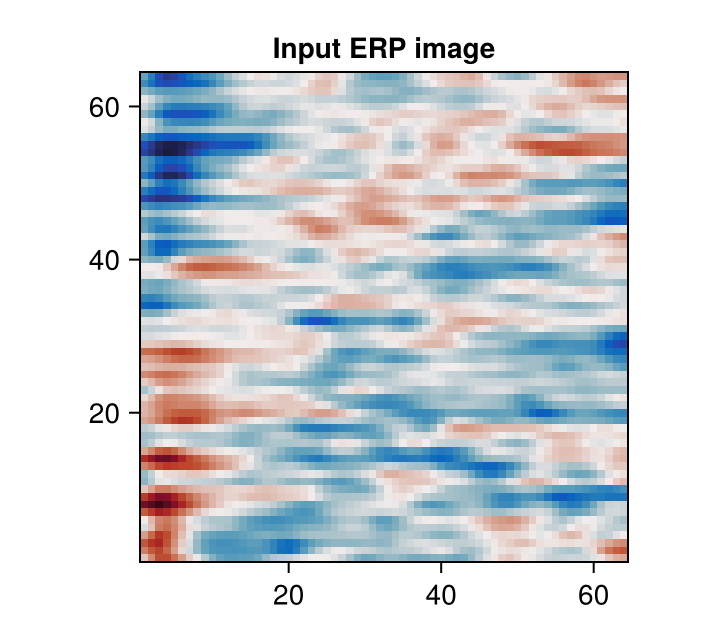

In [14]:
using CairoMakie

sample_idx = rand(1:size(test_X, 4))
sample_img = test_X[:, :, 1, sample_idx]
sample_scores = test_scores[:, sample_idx]

true_lbl = pattern_names[y_true[sample_idx] + 1]
pred_lbl = pattern_names[y_pred[sample_idx] + 1]

println("Sample index: ", sample_idx)
println("True label : ", true_lbl)
println("Pred label : ", pred_lbl)
println("Scores:")
for (name, score) in format_scores(sample_scores, pattern_names)
    println("  ", name, " => ", round(score, digits = 4))
end

fig = Figure(size = (360, 320))
ax = Axis(fig[1, 1]; title = "Input ERP image", aspect = AxisAspect(1))
heatmap!(ax, permutedims(sample_img, (2, 1)); colormap = :balance)
fig



Output scores:
  noclass => 1.0
  sigmoid => 0.0
  one_sided_fan => 0.0
  tilted_bar => 0.0
  diverging_bar => 0.0
  hourglass => 0.0
  two_sided_fan => 0.0


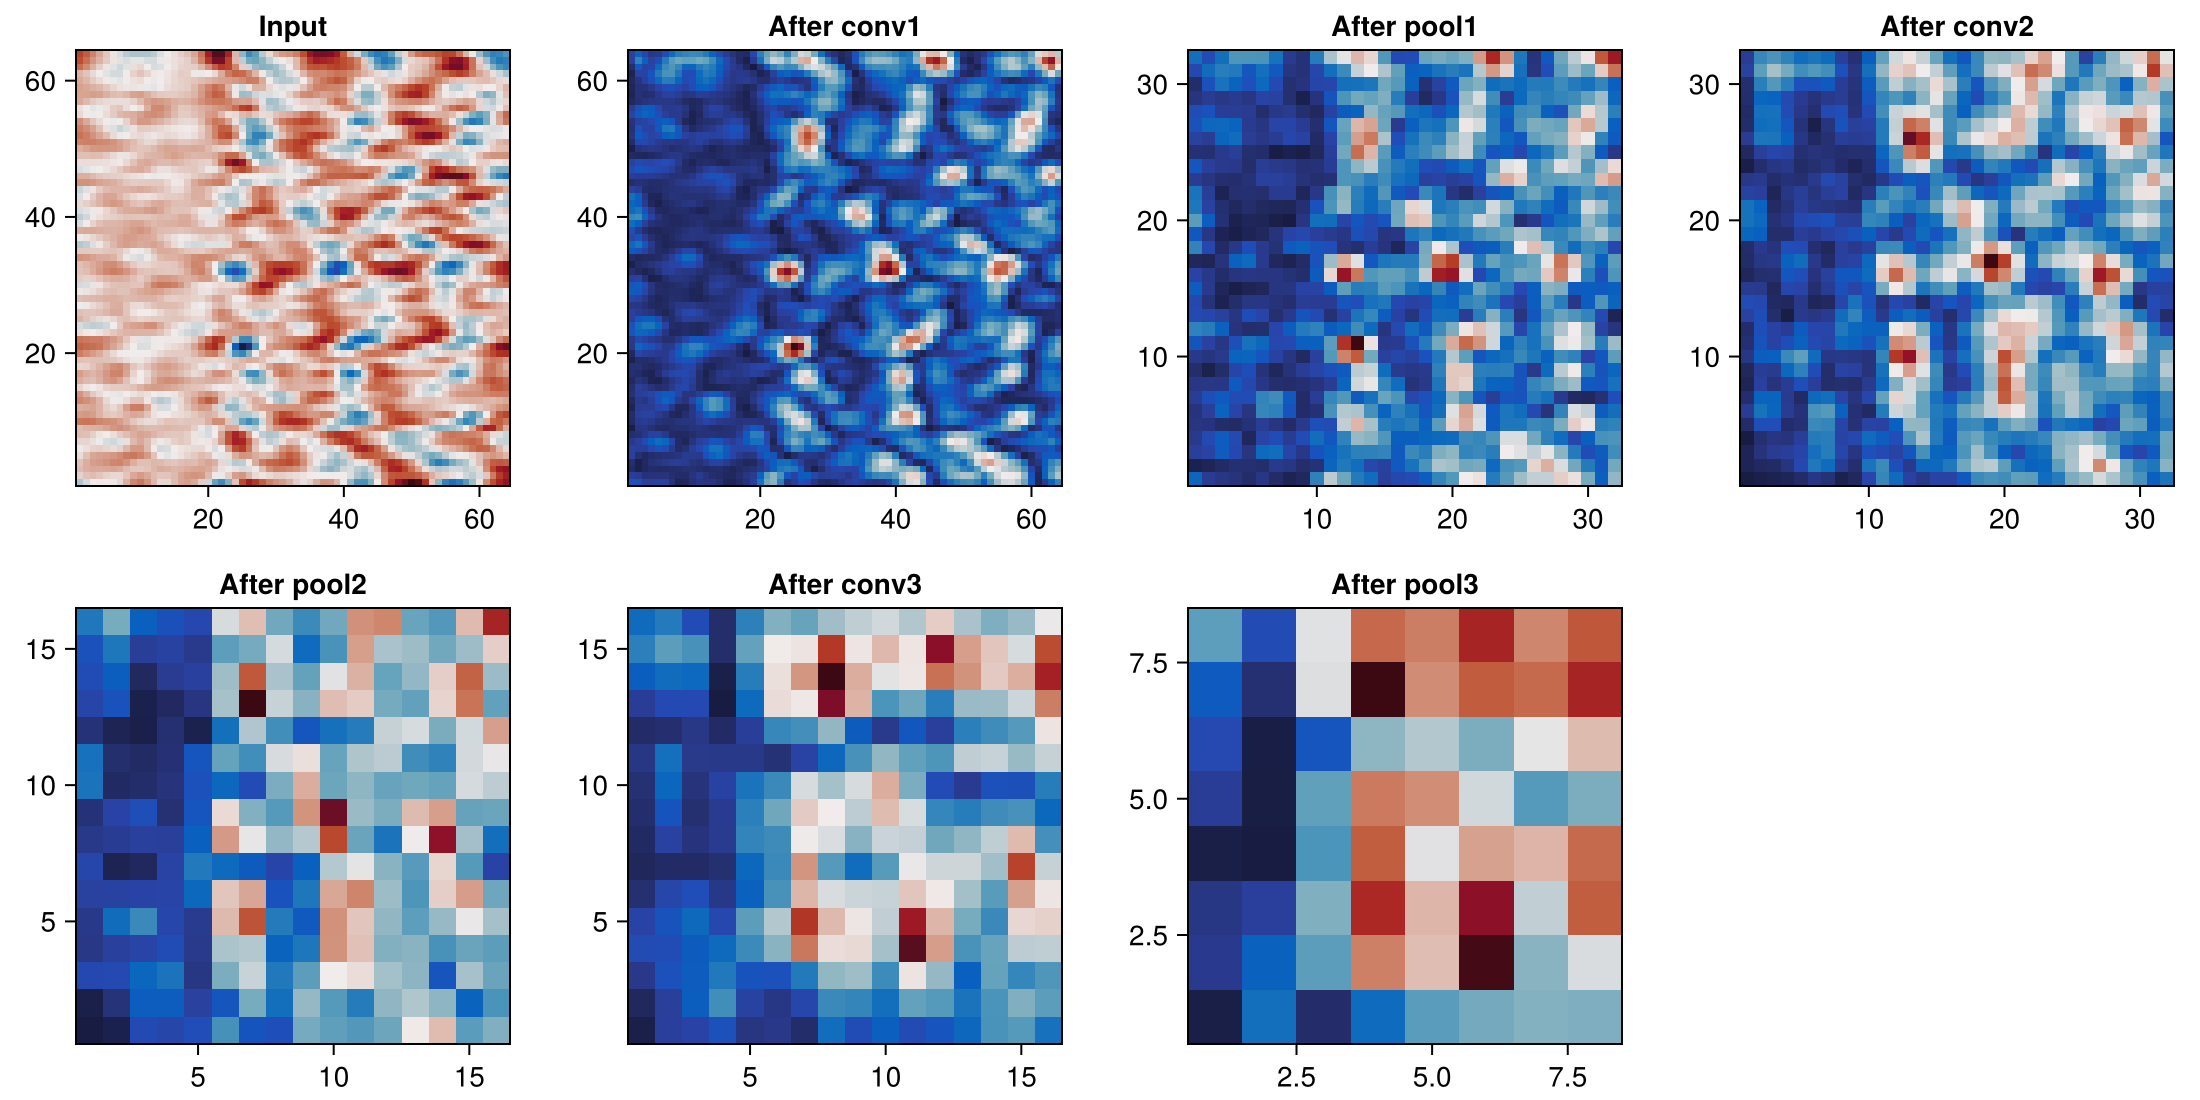

In [15]:
using CairoMakie

sample_idx = rand(1:size(test_X, 4))

x0 = test_X[:, :, :, sample_idx:sample_idx]
x0_dev = device(x0)

block1_dev, block2_dev, block3_dev, head_dev = model[1], model[2], model[3], model[4]
conv1, relu1, pool1 = block1_dev[1], block1_dev[2], block1_dev[3]
conv2, relu2, pool2 = block2_dev[1], block2_dev[2], block2_dev[3]
conv3, relu3, pool3 = block3_dev[1], block3_dev[2], block3_dev[3]

x1c = conv1(x0_dev)
x1 = relu1(x1c)
x1p = pool1(x1)

x2c = conv2(x1p)
x2 = relu2(x2c)
x2p = pool2(x2)

x3c = conv3(x2p)
x3 = relu3(x3c)
x3p = pool3(x3)

scores = cpu(head_dev(x3p))[:, 1]

function to_image(x)
    x_cpu = Array(cpu(x))
    if ndims(x_cpu) == 4
        return dropdims(mean(x_cpu; dims = 3), dims = 3)[:, :, 1]
    elseif ndims(x_cpu) == 3
        return dropdims(mean(x_cpu; dims = 3), dims = 3)
    else
        return x_cpu
    end
end

imgs = [
    to_image(x0),
    to_image(x1),
    to_image(x1p),
    to_image(x2),
    to_image(x2p),
    to_image(x3),
    to_image(x3p),
]

titles = [
    "Input",
    "After conv1",
    "After pool1",
    "After conv2",
    "After pool2",
    "After conv3",
    "After pool3",
]

fig = Figure(size = (1100, 550), figure_padding = 5)
colgap!(fig.layout, 8)
rowgap!(fig.layout, 8)

for (i, img) in enumerate(imgs)
    row = i <= 4 ? 1 : 2
    col = i <= 4 ? i : (i - 4)
    ax = Axis(fig[row, col]; title = titles[i], aspect = AxisAspect(1))
    heatmap!(ax, permutedims(img, (2, 1)); colormap = :balance)
end

println("Output scores:")
for (name, score) in format_scores(scores, pattern_names)
    println("  ", name, " => ", round(score, digits = 4))
end

fig



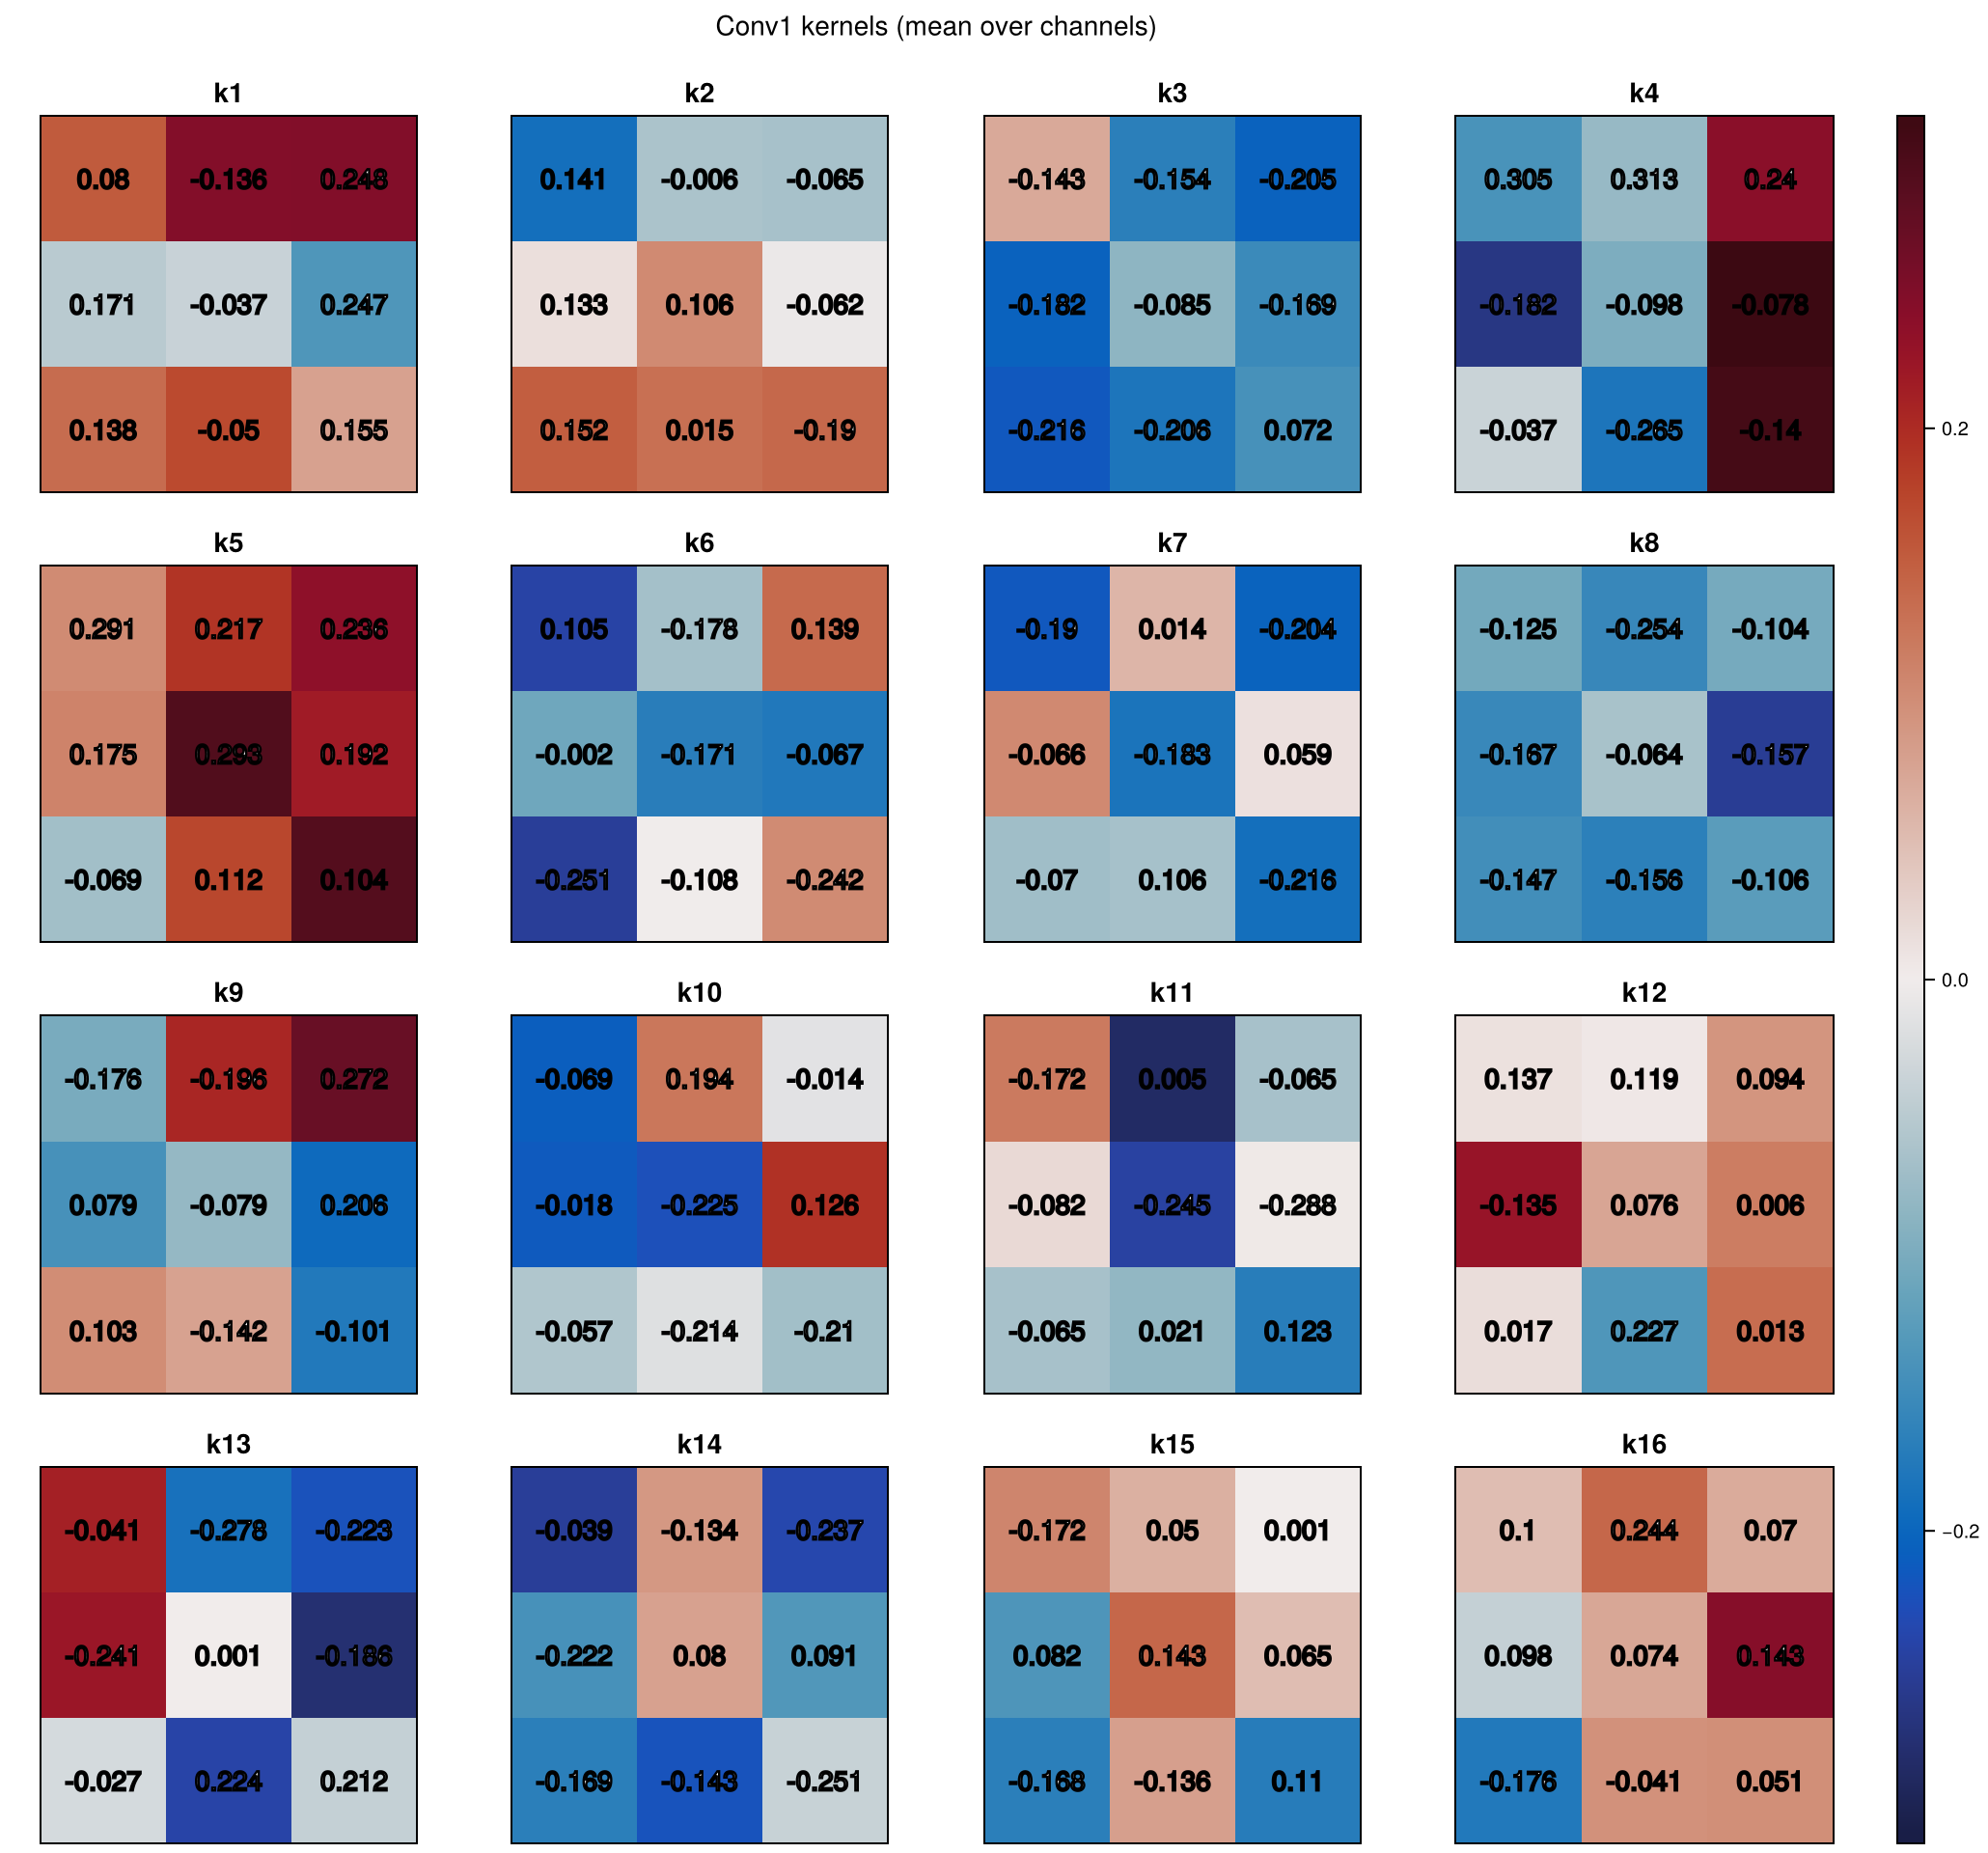

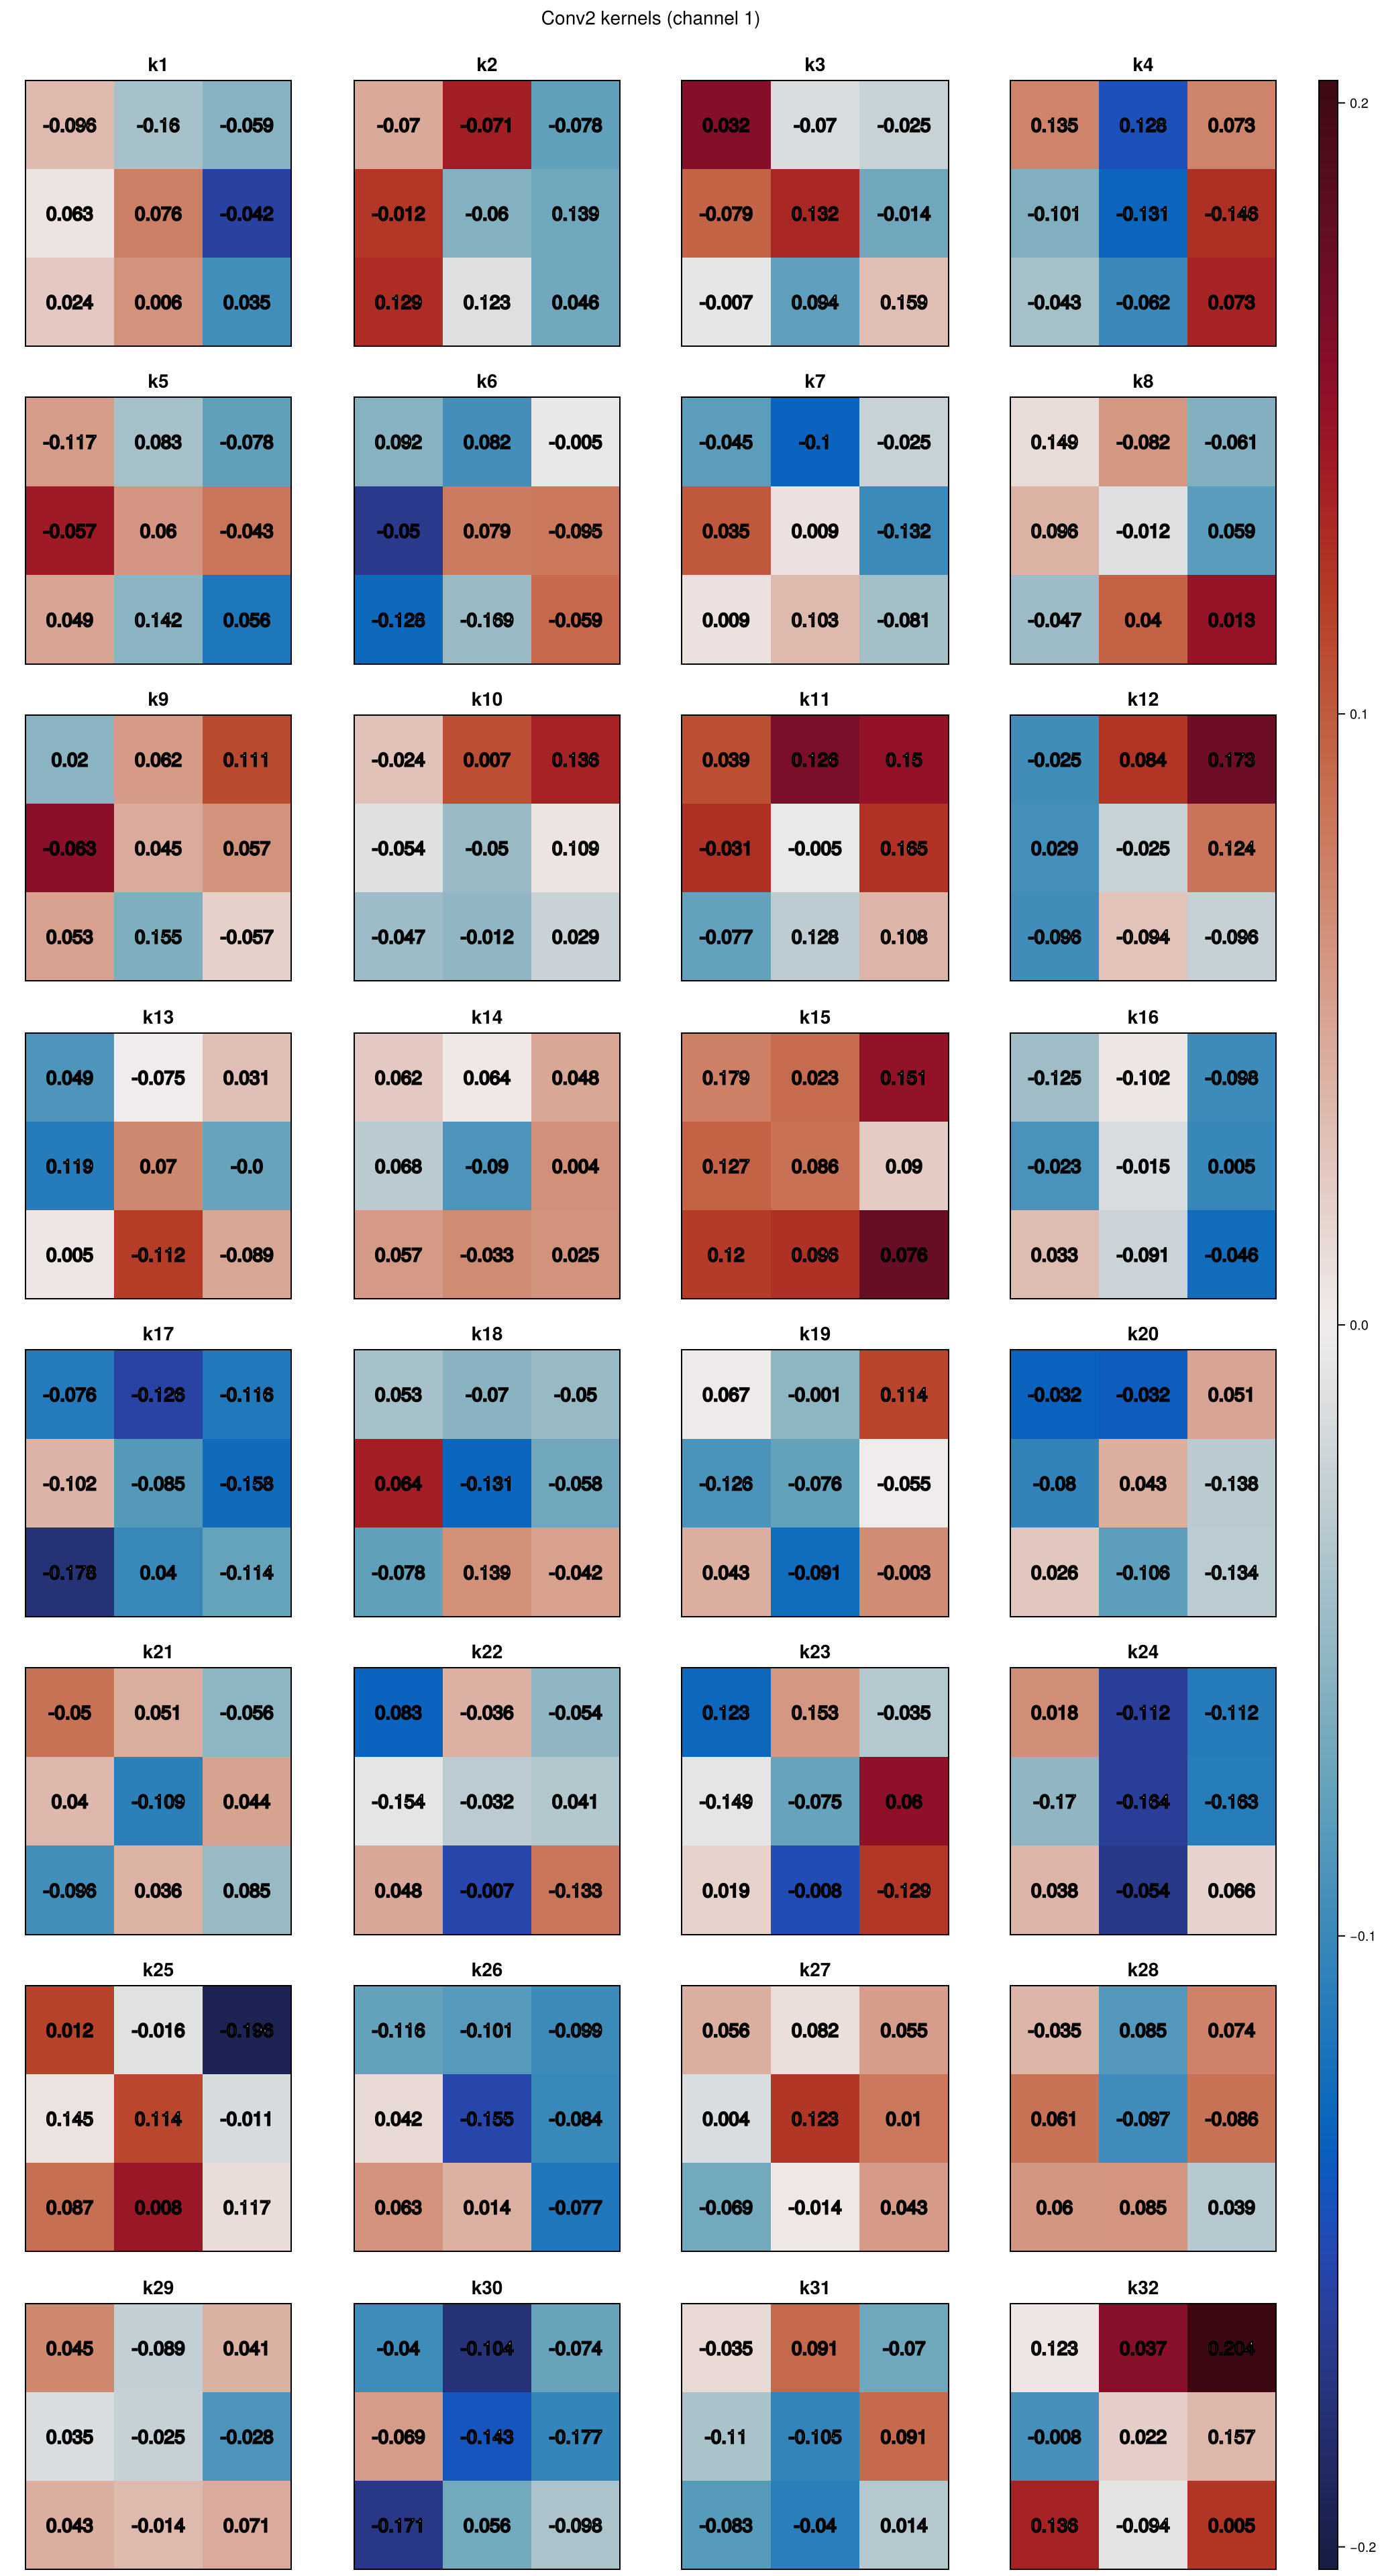

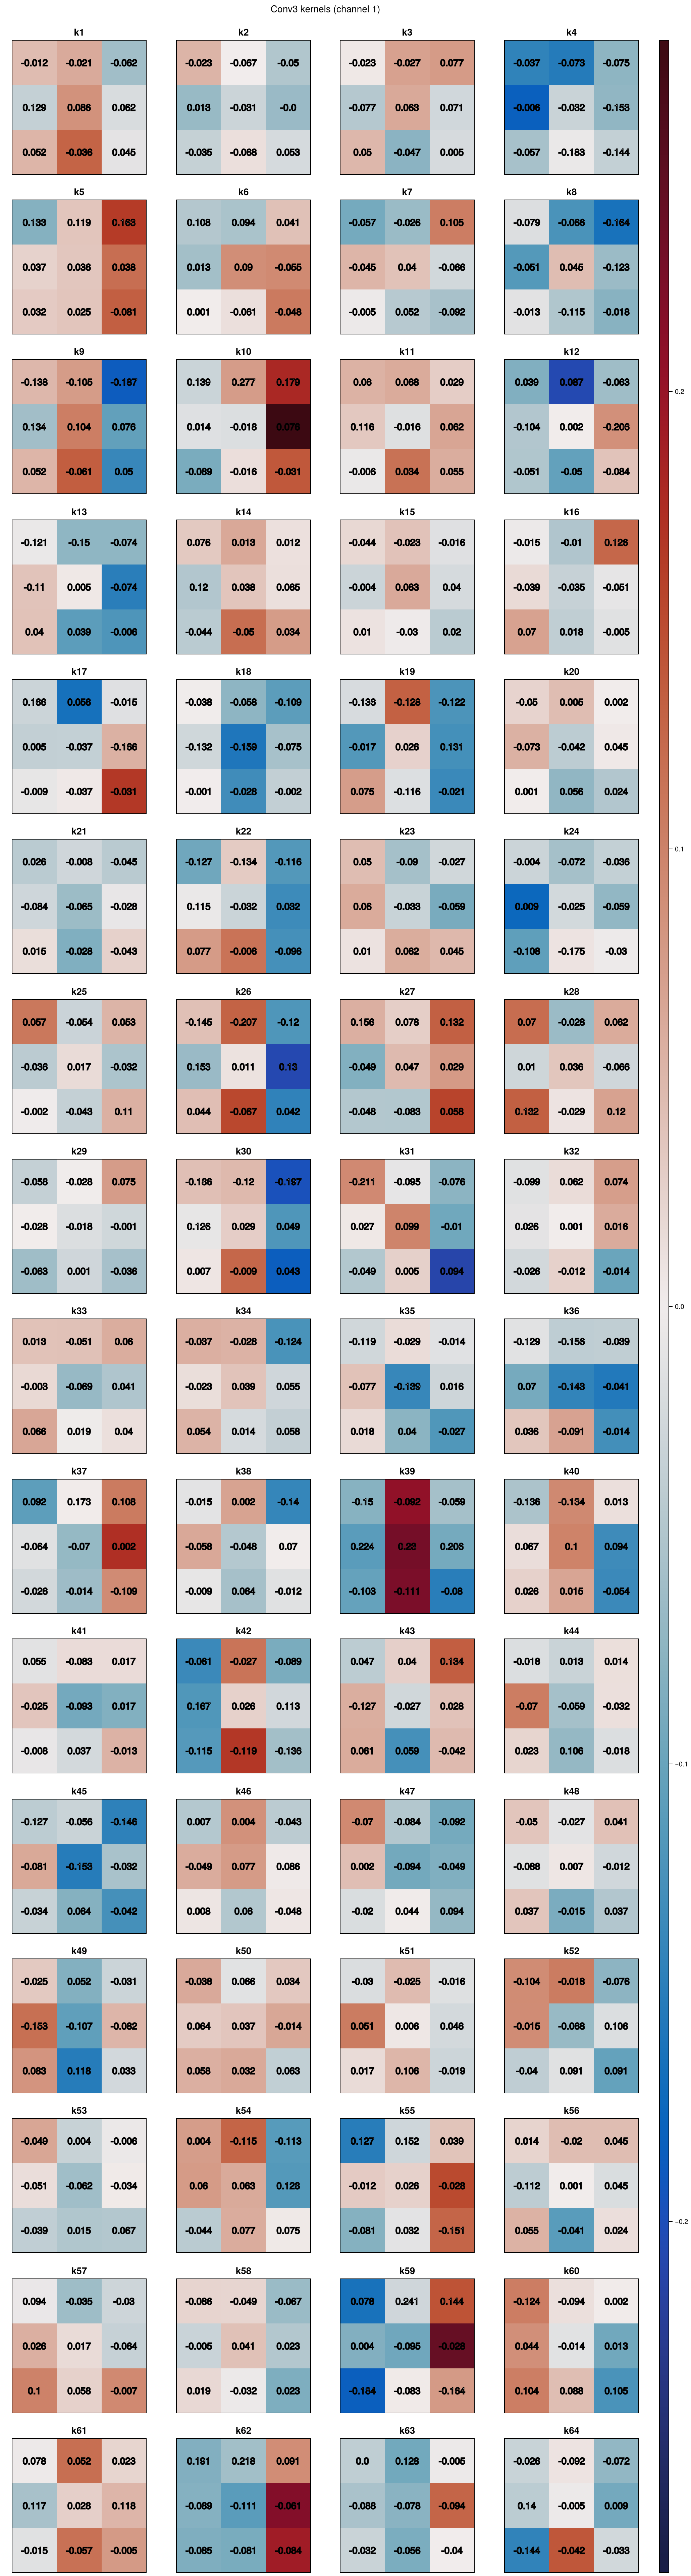


Conv1 kernel values (mean over channels):
Kernel 1:
Float32[0.1378 0.1714 0.0803; -0.0503 -0.0375 -0.1356; 0.1551 0.2471 0.2482]
Kernel 2:
Float32[0.1517 0.1332 0.1413; 0.0147 0.1059 -0.0064; -0.1902 -0.0617 -0.0654]
Kernel 3:
Float32[-0.2163 -0.1817 -0.1426; -0.2056 -0.085 -0.1536; 0.0717 -0.1689 -0.2049]
Kernel 4:
Float32[-0.0368 -0.1819 0.3047; -0.2649 -0.0983 0.3134; -0.1405 -0.0777 0.2403]
Kernel 5:
Float32[-0.0689 0.1745 0.2909; 0.1125 0.2934 0.2173; 0.1043 0.1916 0.236]
Kernel 6:
Float32[-0.2512 -0.0018 0.1048; -0.1085 -0.1708 -0.1782; -0.2421 -0.0672 0.1392]
Kernel 7:
Float32[-0.0705 -0.0655 -0.1901; 0.1062 -0.1833 0.0135; -0.2158 0.0591 -0.2042]
Kernel 8:
Float32[-0.1467 -0.1675 -0.1254; -0.1559 -0.0641 -0.254; -0.106 -0.1566 -0.1036]
Kernel 9:
Float32[0.1027 0.0793 -0.1764; -0.1423 -0.0792 -0.1963; -0.1015 0.2058 0.2717]
Kernel 10:
Float32[-0.0573 -0.0184 -0.0689; -0.2144 -0.2255 0.1943; -0.2099 0.1257 -0.0144]
Kernel 11:
Float32[-0.0652 -0.0819 -0.1716; 0.0209 -0.2452 0.005

In [16]:
using CairoMakie

CairoMakie.activate!()

function kernel_images(w; max_kernels = typemax(Int), channel = :mean)
    w_cpu = Array(cpu(w))
    kh, kw, cin, cout = size(w_cpu)
    nshow = min(max_kernels, cout)
    imgs = Vector{Matrix{Float32}}(undef, nshow)
    for i in 1:nshow
        k = w_cpu[:, :, :, i]
        if channel === :mean
            imgs[i] = dropdims(mean(k; dims = 3), dims = 3)
        else
            ch = clamp(Int(channel), 1, cin)
            imgs[i] = k[:, :, ch]
        end
    end
    return imgs
end

function annotate_heatmap!(ax, mat, vmax; digits = 3)
    rows, cols = size(mat)
    for r in 1:rows
        for c in 1:cols
            val = round(mat[r, c]; digits = digits)
            fg = abs(val) > 0.45 * vmax ? :white : :black
            text!(ax, c, r;
                text = string(val),
                align = (:center, :center),
                color = fg,
                strokecolor = :black,
                strokewidth = 1.2,
                fontsize = 14,
            )
        end
    end
end

function plot_kernels(w; title = "", max_kernels = typemax(Int), channel = :mean, digits = 3)
    imgs = kernel_images(w; max_kernels = max_kernels, channel = channel)
    nshow = length(imgs)
    ncols = min(4, nshow)
    nrows = cld(nshow, ncols)

    fig = Figure(size = (240 * ncols + 70, 240 * nrows), figure_padding = 5)
    colgap!(fig.layout, 8)
    rowgap!(fig.layout, 8)

    vmax = maximum(abs, reduce(hcat, vec.(imgs)))
    vmax = vmax == 0 ? 1f-6 : vmax
    cr = (-vmax, vmax)

    hm_ref = nothing

    for (i, img) in enumerate(imgs)
        row = cld(i, ncols)
        col = i - (row - 1) * ncols
        ax = Axis(fig[row, col];
            title = "k" * string(i),
            aspect = AxisAspect(1),
            xticksvisible = false,
            yticksvisible = false,
            xticklabelsvisible = false,
            yticklabelsvisible = false,
        )

        show_img = permutedims(img, (2, 1))

        hm = heatmap!(ax, show_img;
            colormap = :balance,
            colorrange = cr,
        )
        annotate_heatmap!(ax, show_img, vmax; digits = digits)
        hm_ref === nothing && (hm_ref = hm)
    end

    if !isempty(title)
        Label(fig[0, 1:ncols], title; tellwidth = false)
    end

    if hm_ref !== nothing
        Colorbar(fig[1:nrows, ncols + 1], hm_ref; width = 14, ticklabelsize = 10)
    end

    return fig
end

function print_kernels(w; max_kernels = typemax(Int), channel = :mean, digits = 4)
    w_cpu = Array(cpu(w))
    kh, kw, cin, cout = size(w_cpu)
    nshow = min(max_kernels, cout)
    for i in 1:nshow
        k = w_cpu[:, :, :, i]
        mat = channel === :mean ? dropdims(mean(k; dims = 3), dims = 3) : k[:, :, clamp(Int(channel), 1, cin)]
        println("Kernel ", i, ":")
        println(round.(mat, digits = digits))
    end
end

conv1 = model[1][1].weight
conv2 = model[2][1].weight
conv3 = model[3][1].weight

fig1 = plot_kernels(conv1; title = "Conv1 kernels (mean over channels)", max_kernels = typemax(Int), digits = 3)
fig2 = plot_kernels(conv2; title = "Conv2 kernels (channel 1)", max_kernels = typemax(Int), channel = 1, digits = 3)
fig3 = plot_kernels(conv3; title = "Conv3 kernels (channel 1)", max_kernels = typemax(Int), channel = 1, digits = 3)

display(fig1)
display(fig2)
display(fig3)

println("\nConv1 kernel values (mean over channels):")
print_kernels(conv1; max_kernels = typemax(Int), channel = :mean)

println("\nConv2 kernel values (channel 1):")
print_kernels(conv2; max_kernels = typemax(Int), channel = 1)

println("\nConv3 kernel values (channel 1):")
print_kernels(conv3; max_kernels = typemax(Int), channel = 1)



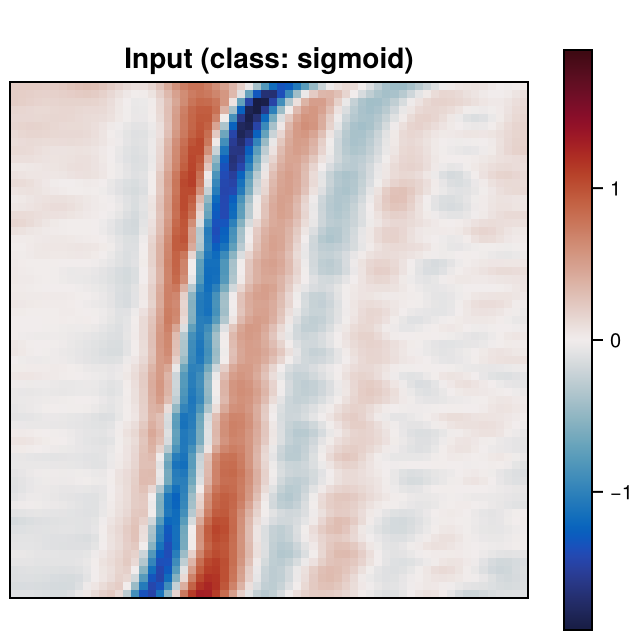

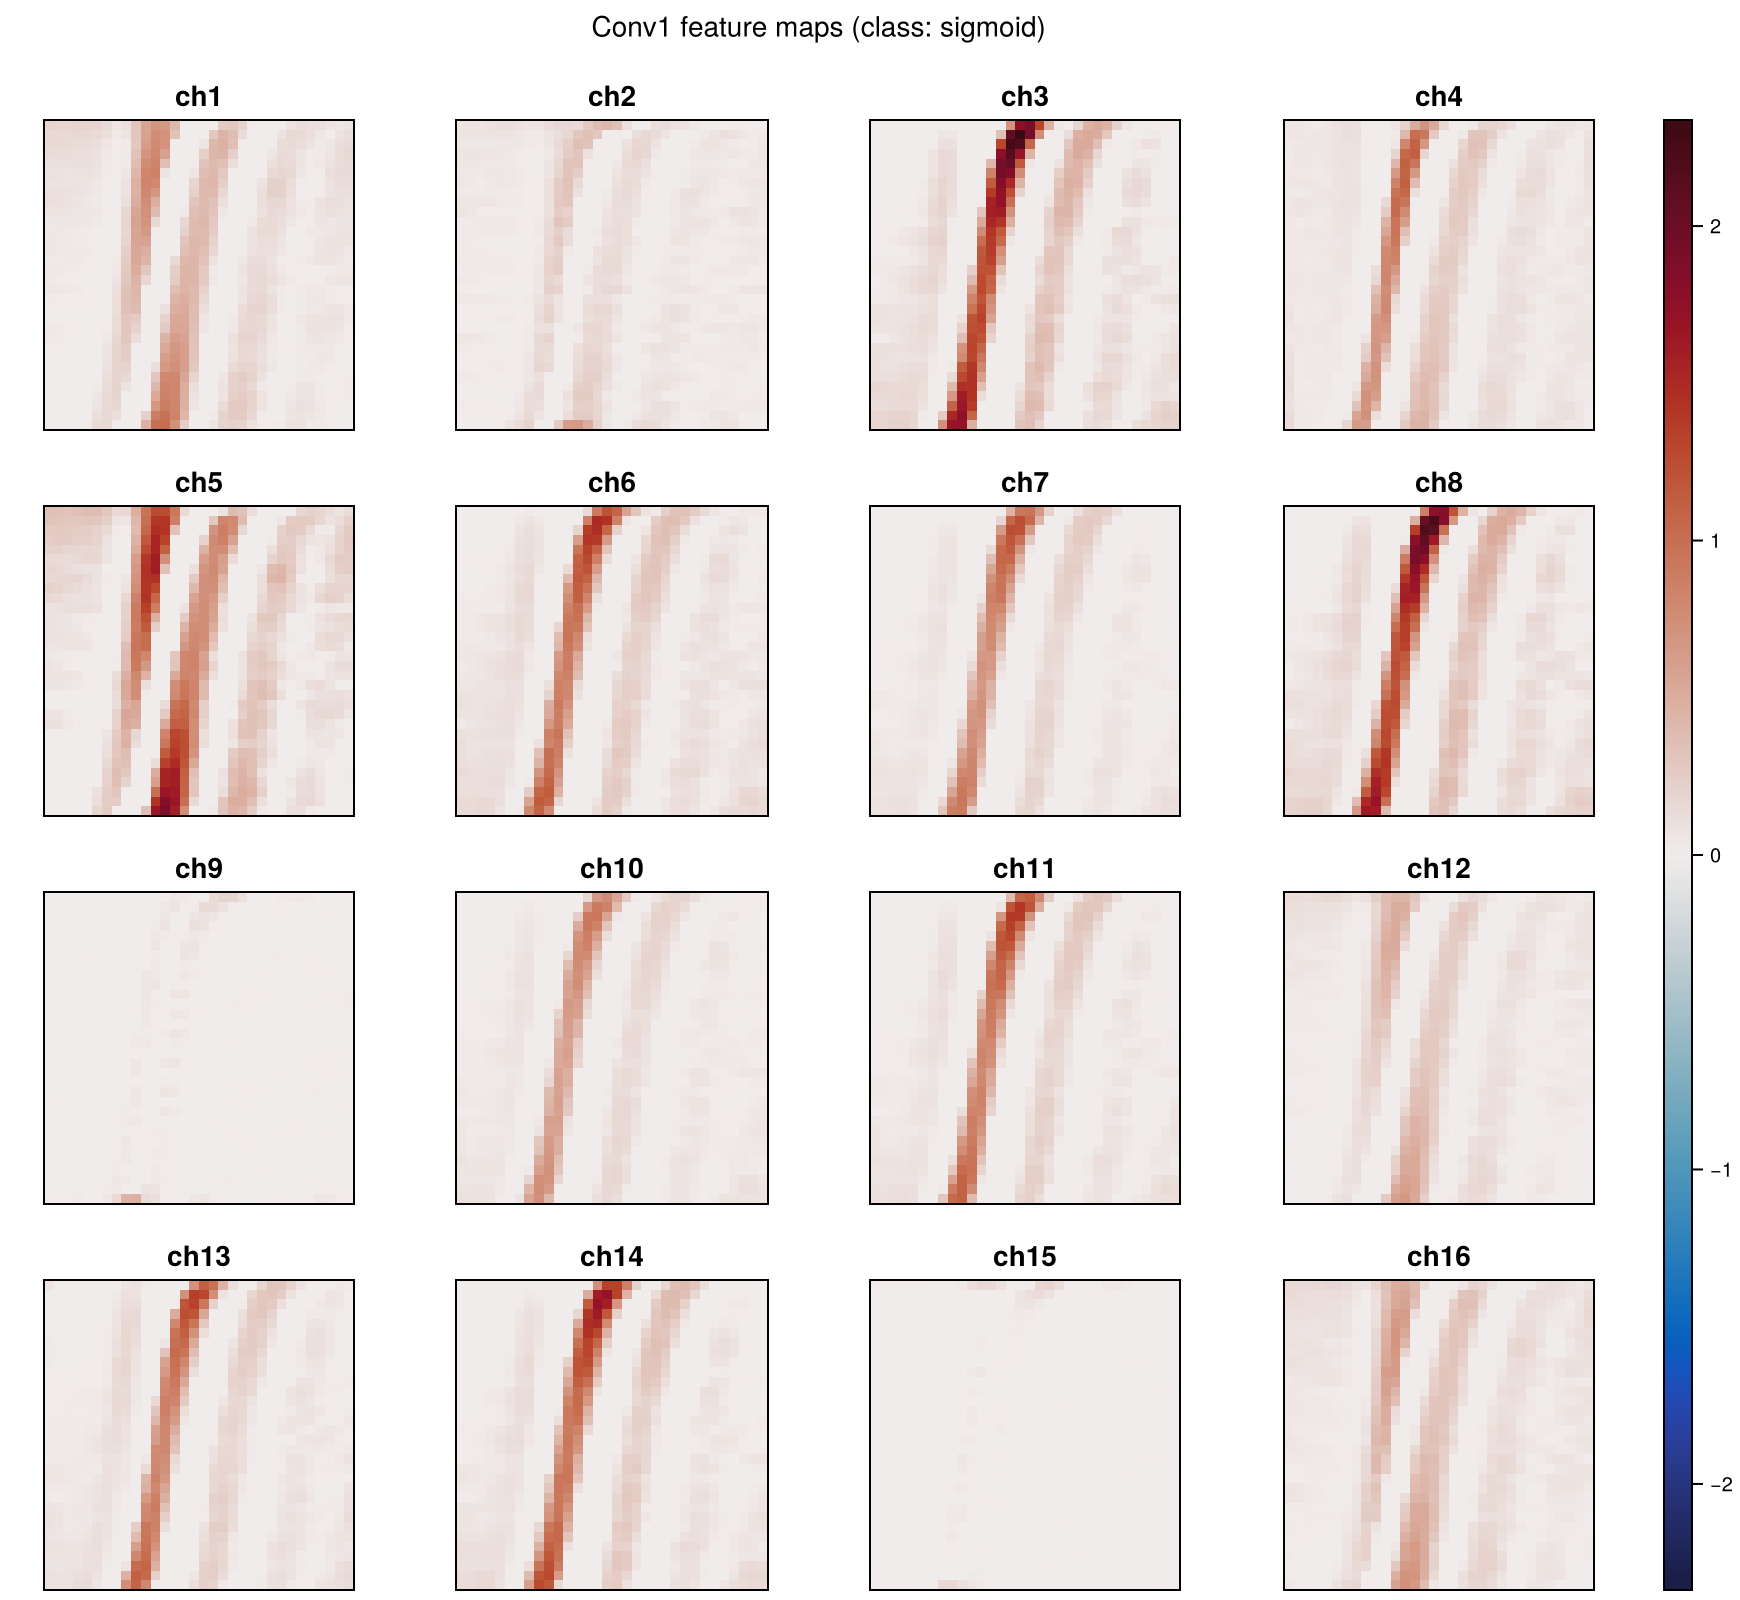

CairoMakie.Screen{IMAGE}


In [17]:
using CairoMakie

CairoMakie.activate!()

# Random test sample (fixed for all feature-map plots below)
sample_idx = rand(1:size(test_X, 4))

x0 = test_X[:, :, :, sample_idx:sample_idx]
x0_dev = device(x0)

block1_dev, block2_dev, block3_dev = model[1], model[2], model[3]

feat1 = Array(cpu(block1_dev(x0_dev)))
feat2 = Array(cpu(block2_dev(block1_dev(x0_dev))))
feat3 = Array(cpu(block3_dev(block2_dev(block1_dev(x0_dev)))))

input_img = Array(cpu(x0))[:, :, 1, 1]

function class_name_for(idx)
    if isdefined(Main, :y_true)
        return string(pattern_names[y_true[idx] + 1])
    end
    if isdefined(Main, :test_Y)
        lbl = onecold(test_Y[:, idx], 0:length(pattern_names)-1)
        return string(pattern_names[lbl + 1])
    end
    return "unknown"
end

class_name = class_name_for(sample_idx)

function plot_input(img; title = "Input")
    vmax = maximum(abs, img)
    vmax = vmax == 0 ? 1f-6 : vmax
    cr = (-vmax, vmax)

    fig = Figure(size = (320, 320), figure_padding = 5)
    ax = Axis(fig[1, 1];
        title = title,
        aspect = AxisAspect(1),
        xticksvisible = false,
        yticksvisible = false,
        xticklabelsvisible = false,
        yticklabelsvisible = false,
    )
    hm = heatmap!(ax, permutedims(img, (2, 1)); colormap = :balance, colorrange = cr)
    Colorbar(fig[1, 2], hm; width = 14, ticklabelsize = 10)
    return fig
end

function plot_feature_grid(feat; title = "")
    nshow = size(feat, 3)
    ncols = nshow <= 16 ? 4 : nshow <= 64 ? 8 : 10
    nrows = cld(nshow, ncols)
    tile = nshow <= 16 ? 200 : nshow <= 64 ? 140 : 120

    vmax = maximum(abs, feat)
    vmax = vmax == 0 ? 1f-6 : vmax
    cr = (-vmax, vmax)

    fig = Figure(size = (tile * ncols + 70, tile * nrows), figure_padding = 5)
    colgap!(fig.layout, 6)
    rowgap!(fig.layout, 6)

    hm_ref = nothing
    for i in 1:nshow
        row = cld(i, ncols)
        col = i - (row - 1) * ncols
        ax = Axis(fig[row, col];
            title = "ch" * string(i),
            aspect = AxisAspect(1),
            xticksvisible = false,
            yticksvisible = false,
            xticklabelsvisible = false,
            yticklabelsvisible = false,
        )
        img = feat[:, :, i, 1]
        hm = heatmap!(ax, permutedims(img, (2, 1)); colormap = :balance, colorrange = cr)
        hm_ref === nothing && (hm_ref = hm)
    end

    if !isempty(title)
        Label(fig[0, 1:ncols], title; tellwidth = false)
    end

    if hm_ref !== nothing
        Colorbar(fig[1:nrows, ncols + 1], hm_ref; width = 14, ticklabelsize = 10)
    end

    return fig
end

display(plot_input(input_img; title = "Input (class: " * class_name * ")"))
display(plot_feature_grid(feat1; title = "Conv1 feature maps (class: " * class_name * ")"))



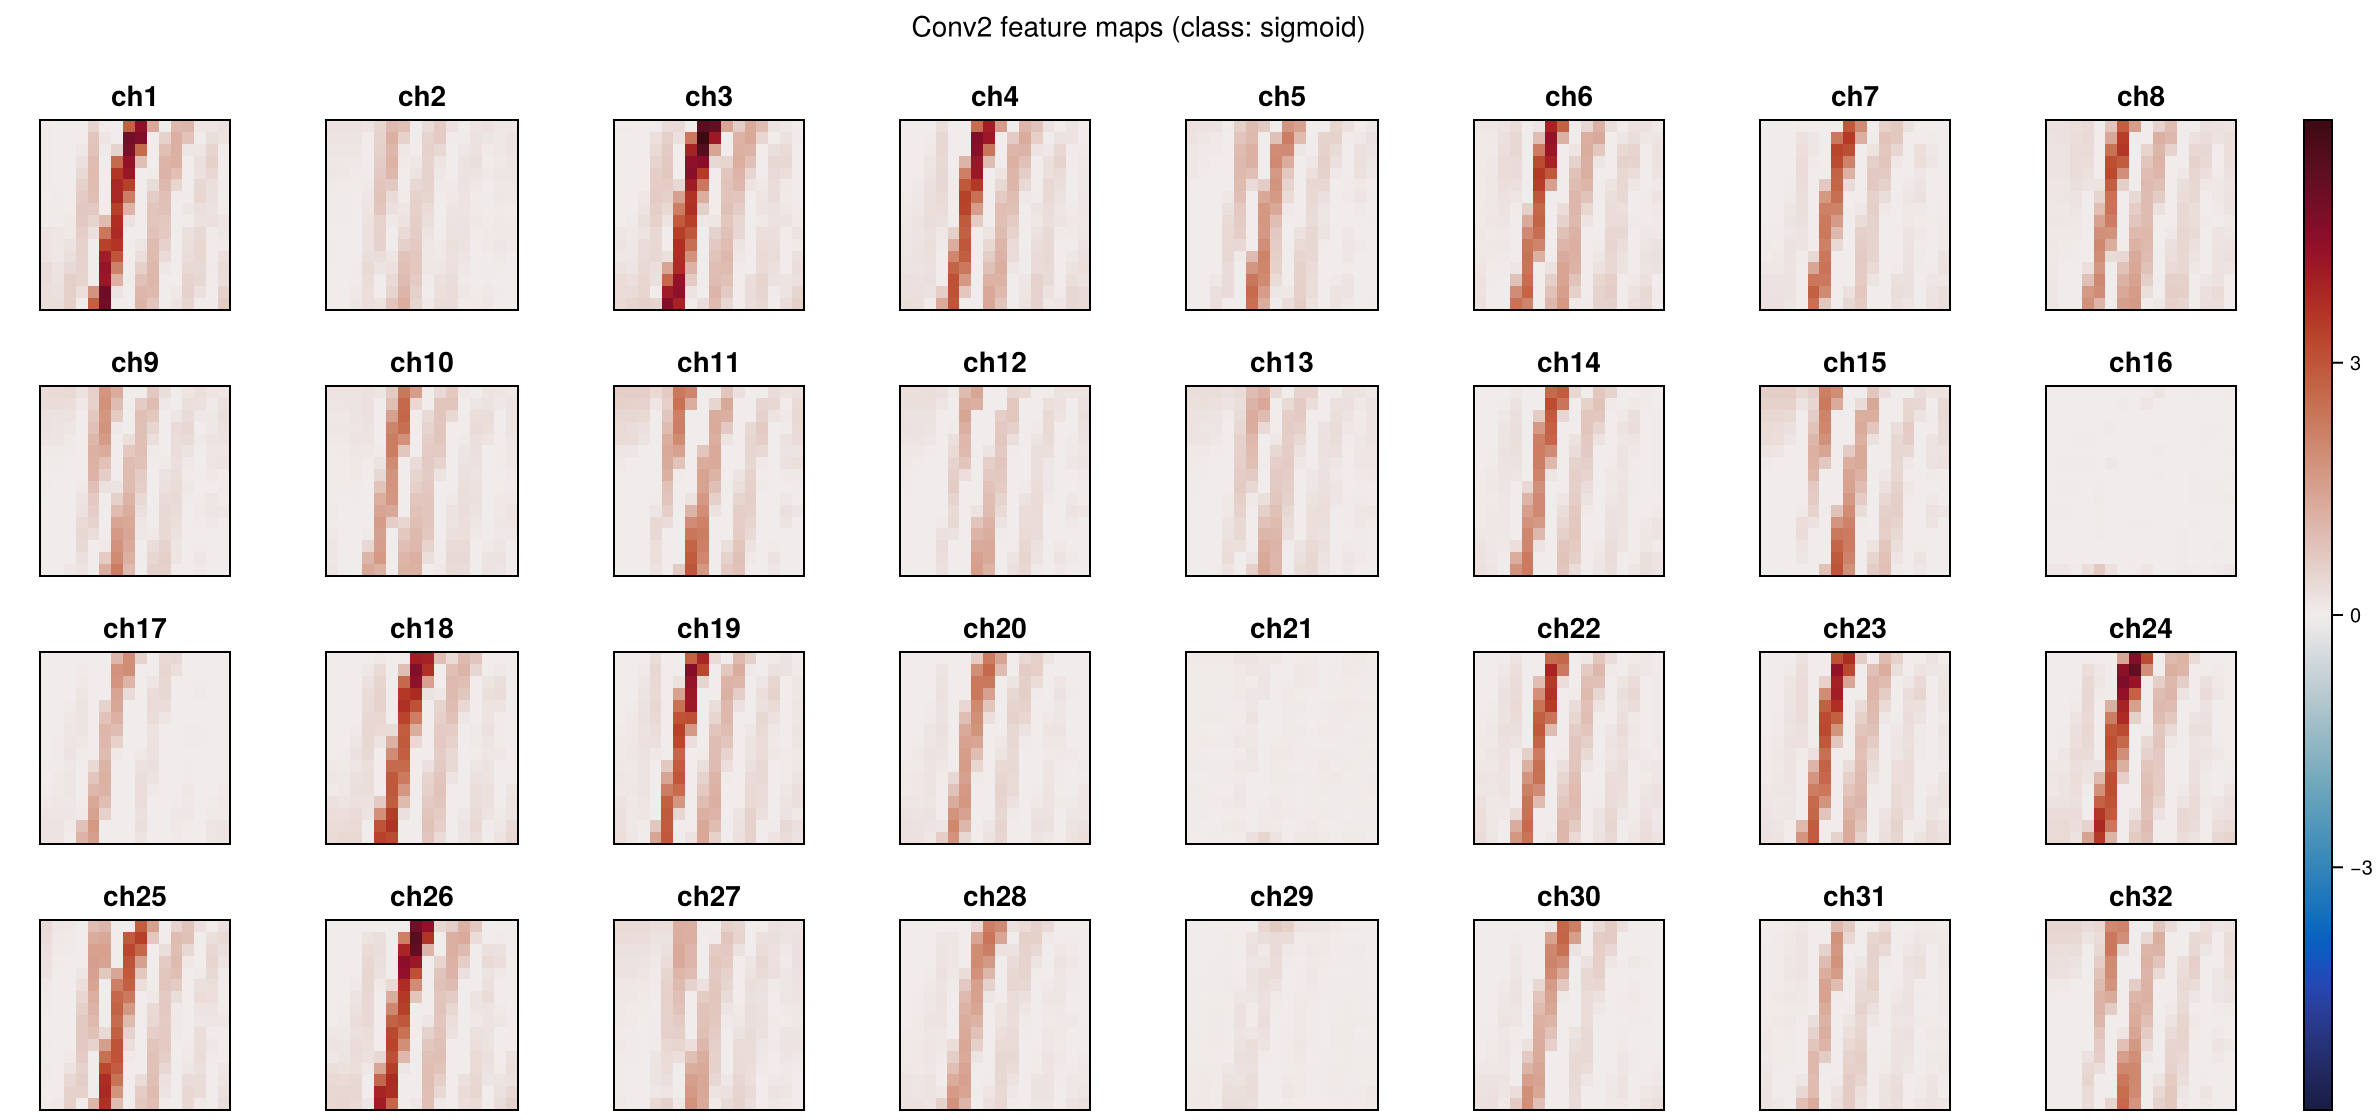

CairoMakie.Screen{IMAGE}


In [18]:
using CairoMakie

# Uses sample_idx, feat2, plot_feature_grid from the previous cell

display(plot_feature_grid(feat2; title = "Conv2 feature maps (class: " * class_name * ")"))



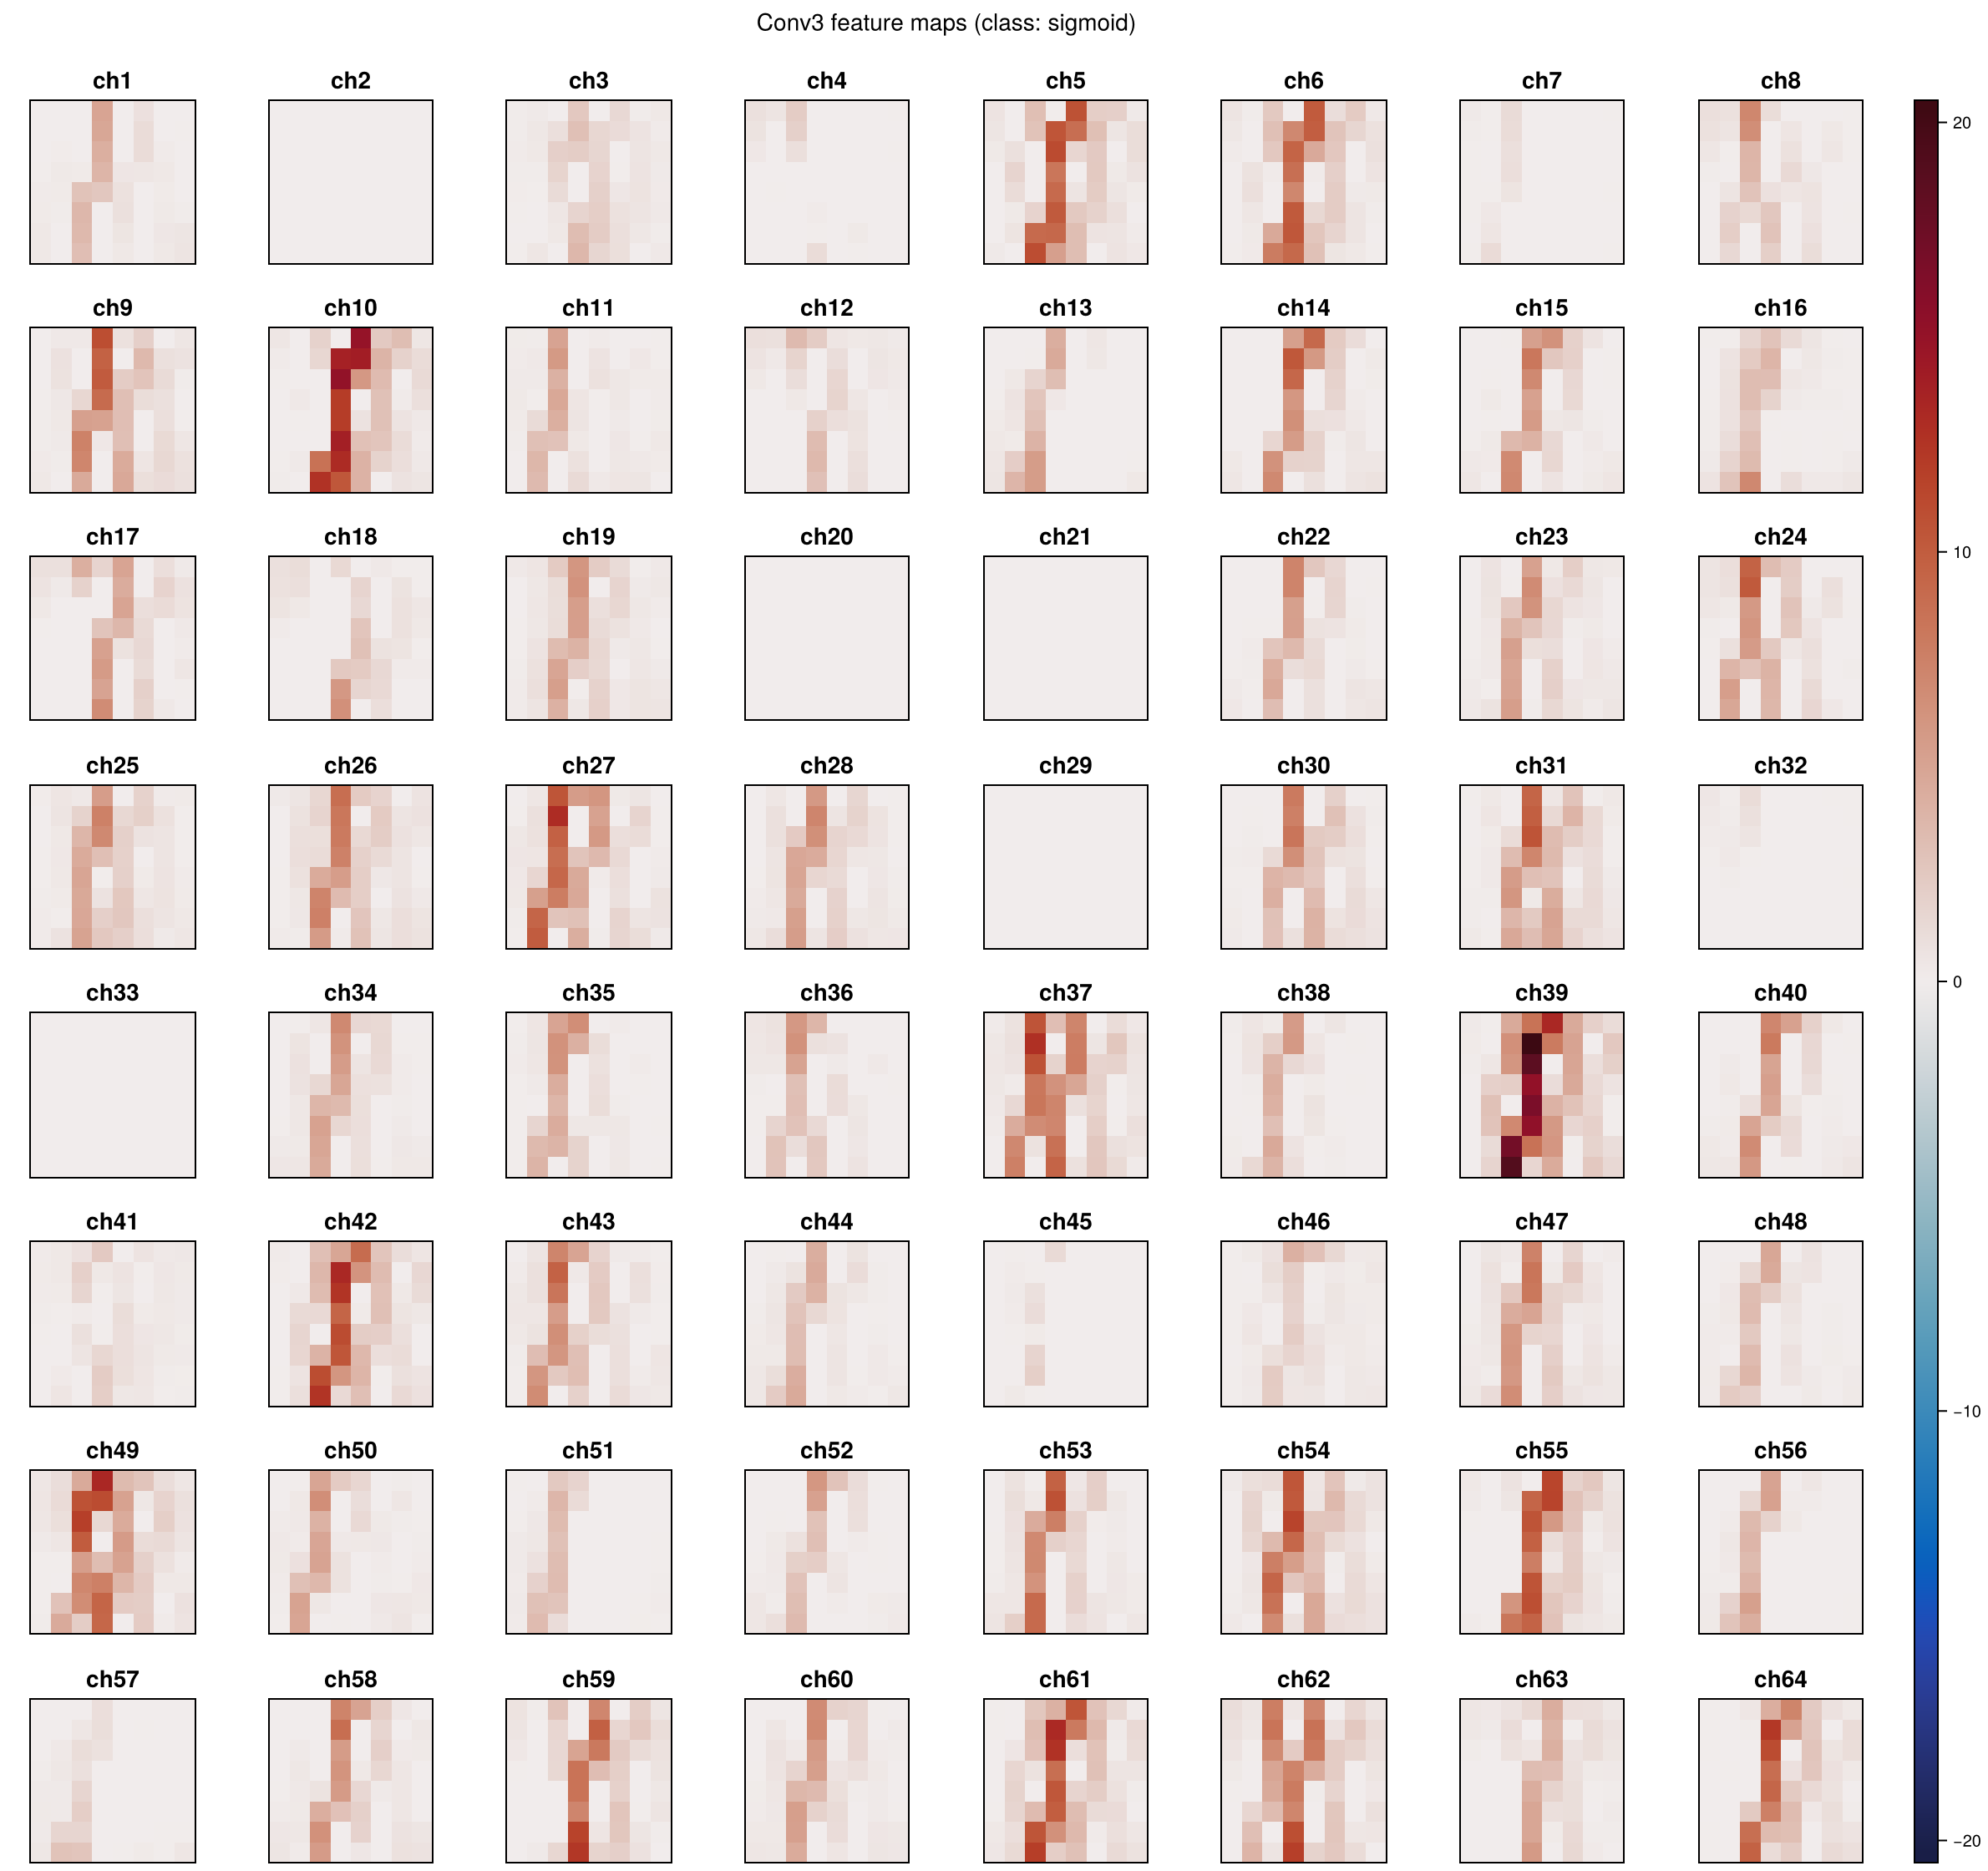

CairoMakie.Screen{IMAGE}


In [19]:
using CairoMakie

# Uses sample_idx, feat3, plot_feature_grid from the previous cell

display(plot_feature_grid(feat3; title = "Conv3 feature maps (class: " * class_name * ")"))



In [ ]:
using JLD2, Dates, Flux

model_dir = abspath(joinpath(pwd(), "..", "model_test"))
mkpath(model_dir)

stamp = Dates.format(now(), "yyyymmdd_HHMMSS")
model_path = joinpath(model_dir, "cnn_model_" * stamp * ".jld2")

model_cpu = cpu(model)

jldsave(model_path;
    model = model_cpu,
    model_state = Flux.state(model_cpu),
    pattern_names = pattern_names,
    saved_at = stamp,
)

println("Saved model to: ", model_path)


